# Hybrid CatBoost–SARIMAX Framework for Multi-City AQI Prediction

This study proposes a hybrid modeling framework combining CatBoost regression
with SARIMAX residual modeling for daily AQI prediction across six major Indian cities.

The objective is to capture nonlinear pollutant interactions (CatBoost)
alongside residual temporal patterns (SARIMAX).

In [1]:
!pip install catboost lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

DATA_FOLDER = "/content/drive/MyDrive/AQI_Hybrid_Project/city_data/"
print(os.listdir(DATA_FOLDER))

['Kolkata.csv', 'Delhi.csv', 'Bengaluru.csv', 'Mumbai.csv', 'Chennai.csv', 'Jaipur.csv']


In [4]:
import os
import glob
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import math

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

In [5]:
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))
print("Found files:", csv_files)

city_dfs = {}

for fp in csv_files:
    city = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp)

    df.columns = [c.strip() for c in df.columns]

    # Timestamp
    if "Date" in df.columns:
        df["Timestamp"] = pd.to_datetime(df["Date"], errors="coerce")
    else:
        raise ValueError(f"No Date column found in {city}")

    df = df.dropna(subset=["Timestamp"])
    df = df.sort_values("Timestamp").set_index("Timestamp")

    # Convert numeric columns
    for col in df.columns:
        if col != "Date":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # ❗ Remove rows where ALL pollutant values are missing
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df.dropna(subset=numeric_cols, how="all")

    # Forward fill
    df = df.ffill()

    # Median fill remaining
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    city_dfs[city] = df
    print(f"{city}: rows={len(df)}")

Found files: ['/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Bengaluru.csv', '/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Chennai.csv', '/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Delhi.csv', '/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Jaipur.csv', '/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Kolkata.csv', '/content/drive/MyDrive/AQI_Hybrid_Project/city_data/Mumbai.csv']
Bengaluru: rows=2802
Chennai: rows=2922
Delhi: rows=2922
Jaipur: rows=2922
Kolkata: rows=2922
Mumbai: rows=2922


In [6]:
city_dfs_continuous = {}

for city, df in city_dfs.items():

    df = df.copy()

    # Create full daily date range
    full_range = pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq="D"
    )

    # Reindex to daily frequency
    df = df.reindex(full_range)

    # Forward fill
    df = df.ffill()

    # Median fill remaining numeric
    df = df.fillna(df.median(numeric_only=True))

    city_dfs_continuous[city] = df

    print(f"{city}: After reindex -> rows={len(df)}")

Bengaluru: After reindex -> rows=2922
Chennai: After reindex -> rows=2922
Delhi: After reindex -> rows=2922
Jaipur: After reindex -> rows=2922
Kolkata: After reindex -> rows=2922
Mumbai: After reindex -> rows=2922


In [7]:
results_store = {}
for city, df in city_dfs_continuous.items():

    if "AQI" not in df.columns:
        print(f"{city}: AQI not found — skipping")
        continue

    df = df.dropna(subset=["AQI"]).copy()

    results_store[city] = {
        "df": df,
        "TARGET": "AQI"
    }

    print(f"{city}: Using AQI as target | Rows = {len(df)}")

Bengaluru: Using AQI as target | Rows = 2922
Chennai: Using AQI as target | Rows = 2922
Delhi: Using AQI as target | Rows = 2922
Jaipur: Using AQI as target | Rows = 2922
Kolkata: Using AQI as target | Rows = 2922
Mumbai: Using AQI as target | Rows = 2922


In [8]:
def cap_outliers_iqr(series, threshold=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR
    upper = Q3 + threshold * IQR
    return series.clip(lower, upper)


def create_time_series_features(df, target):

    df = df.copy()

    # Calendar features
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["year"] = df.index.year

    # Lags
    for lag in [1,2,3,7,14]:
        df[f"{target}_lag{lag}"] = df[target].shift(lag)

    # Rolling mean
    df[f"{target}_roll7"] = df[target].shift(1).rolling(7).mean()

    df = df.dropna()
    return df


city_features = {}

for city, meta in results_store.items():

    df = meta["df"].copy()

    # Cap outliers (excluding AQI)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "AQI" in num_cols:
        num_cols.remove("AQI")

    for col in num_cols:
        df[col] = cap_outliers_iqr(df[col])

    df_feat = create_time_series_features(df, "AQI")

    city_features[city] = df_feat

    print(f"{city}: rows after feature engineering = {len(df_feat)}")

Bengaluru: rows after feature engineering = 2908
Chennai: rows after feature engineering = 2908
Delhi: rows after feature engineering = 2908
Jaipur: rows after feature engineering = 2908
Kolkata: rows after feature engineering = 2908
Mumbai: rows after feature engineering = 2908


In [9]:
splits_store = {}

for city, df in city_features.items():

    X = df.select_dtypes(include=[np.number]).drop(columns=["AQI"])
    y = df["AQI"]

    split_index = int(len(df) * 0.8)

    X_train = X.iloc[:split_index]
    X_test  = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test  = y.iloc[split_index:]

    splits_store[city] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

    print(f"{city}: Train={len(X_train)}, Test={len(X_test)}")

Bengaluru: Train=2326, Test=582
Chennai: Train=2326, Test=582
Delhi: Train=2326, Test=582
Jaipur: Train=2326, Test=582
Kolkata: Train=2326, Test=582
Mumbai: Train=2326, Test=582


In [10]:
models_store = {}

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import math

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

for city, data in splits_store.items():

    print(f"\nTraining CatBoost for {city}")

    X_train = data["X_train"]
    X_test  = data["X_test"]
    y_train = data["y_train"]
    y_test  = data["y_test"]

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.03,
        depth=6,
        loss_function="RMSE",
        random_seed=42,
        verbose=200,
        early_stopping_rounds=100
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        use_best_model=True
    )

    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    rmse_cb = rmse(y_test, pred_test)
    r2_cb = r2_score(y_test, pred_test)

    print(f"{city} — CatBoost RMSE: {rmse_cb:.2f}, R2: {r2_cb:.3f}")

    models_store[city] = {
        "model": model,
        "y_train": y_train,
        "y_test": y_test,
        "pred_train": pred_train,
        "pred_test": pred_test
    }


Training CatBoost for Bengaluru
0:	learn: 27.2956332	test: 24.6825737	best: 24.6825737 (0)	total: 109ms	remaining: 3m 38s
200:	learn: 9.8432082	test: 8.9621207	best: 8.9580649 (195)	total: 4.3s	remaining: 38.5s
400:	learn: 8.1620749	test: 8.7614524	best: 8.7493591 (387)	total: 7.93s	remaining: 31.6s
600:	learn: 6.9414671	test: 8.7581998	best: 8.7295438 (558)	total: 13s	remaining: 30.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 8.72954377
bestIteration = 558

Shrink model to first 559 iterations.
Bengaluru — CatBoost RMSE: 8.73, R2: 0.876

Training CatBoost for Chennai
0:	learn: 30.9790570	test: 20.7941774	best: 20.7941774 (0)	total: 18.1ms	remaining: 36.2s
200:	learn: 11.9965407	test: 9.8688576	best: 9.8545943 (190)	total: 1.65s	remaining: 14.8s
400:	learn: 9.9132966	test: 9.6595997	best: 9.6545139 (398)	total: 3.04s	remaining: 12.1s
600:	learn: 8.4520553	test: 9.5863156	best: 9.5829627 (578)	total: 4.44s	remaining: 10.3s
800:	learn: 7.2717471	test: 9.5379900	


Residual analysis for Bengaluru


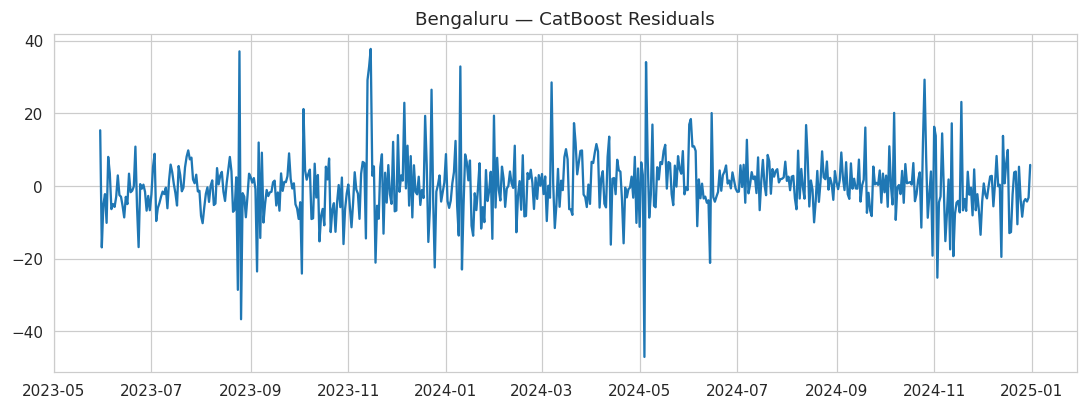

<Figure size 1100x440 with 0 Axes>

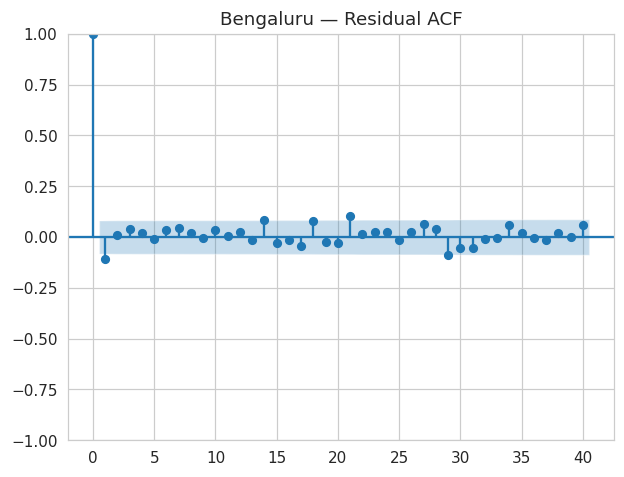


Residual analysis for Chennai


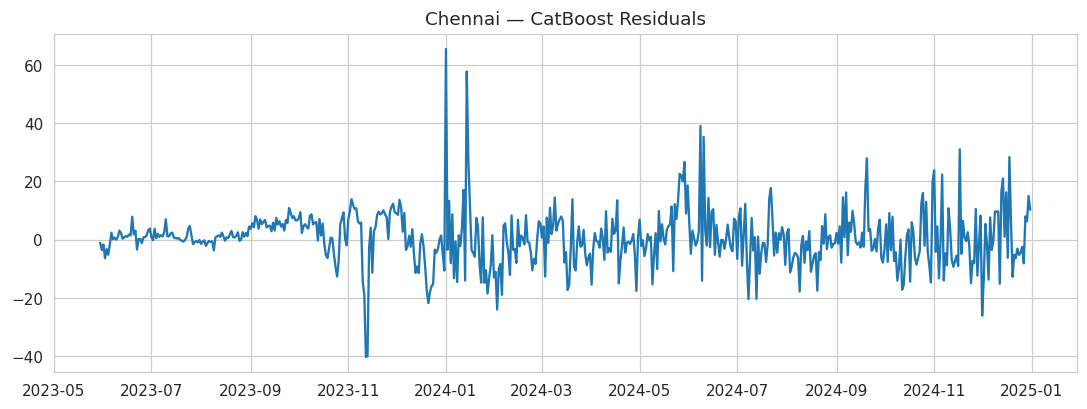

<Figure size 1100x440 with 0 Axes>

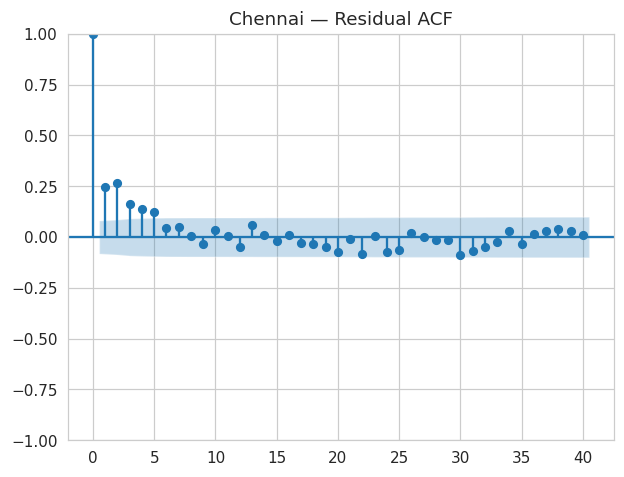


Residual analysis for Delhi


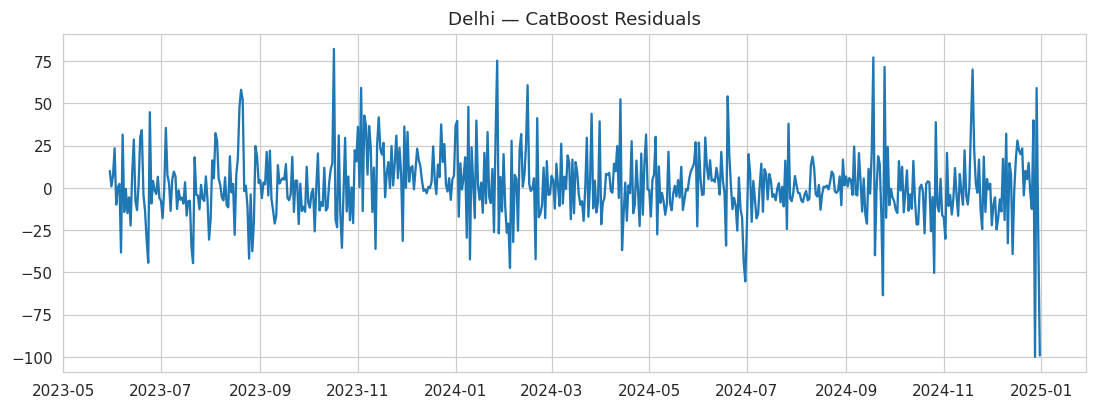

<Figure size 1100x440 with 0 Axes>

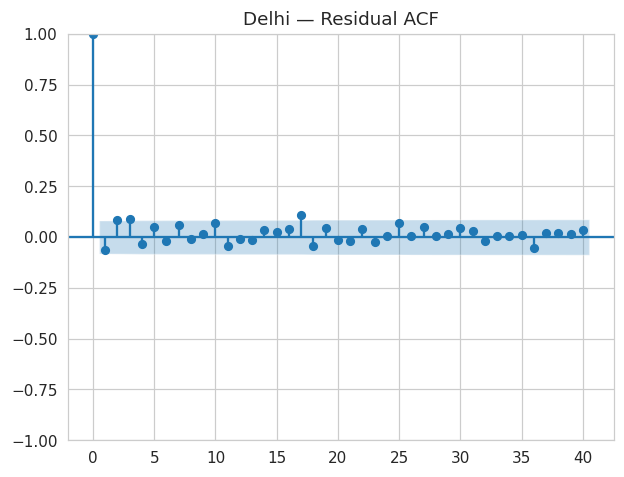


Residual analysis for Jaipur


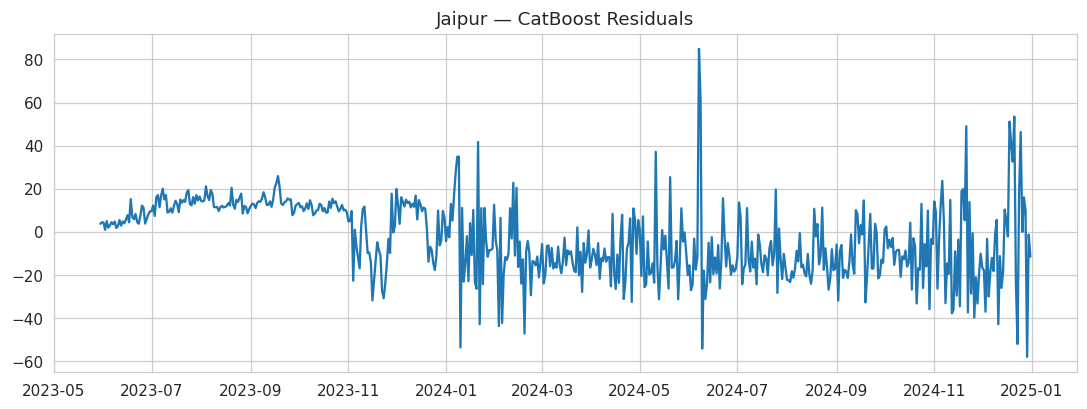

<Figure size 1100x440 with 0 Axes>

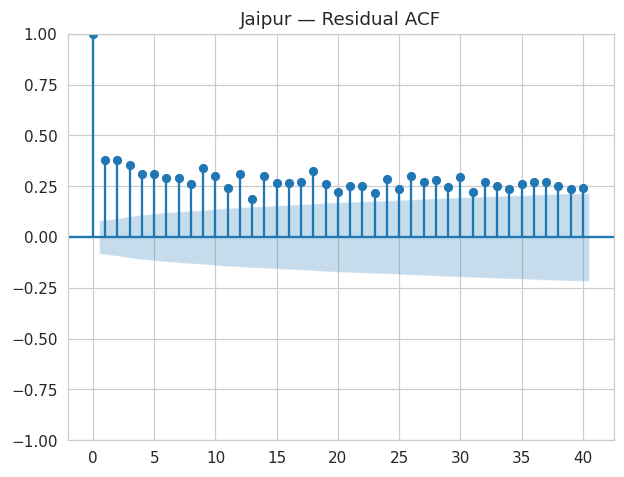


Residual analysis for Kolkata


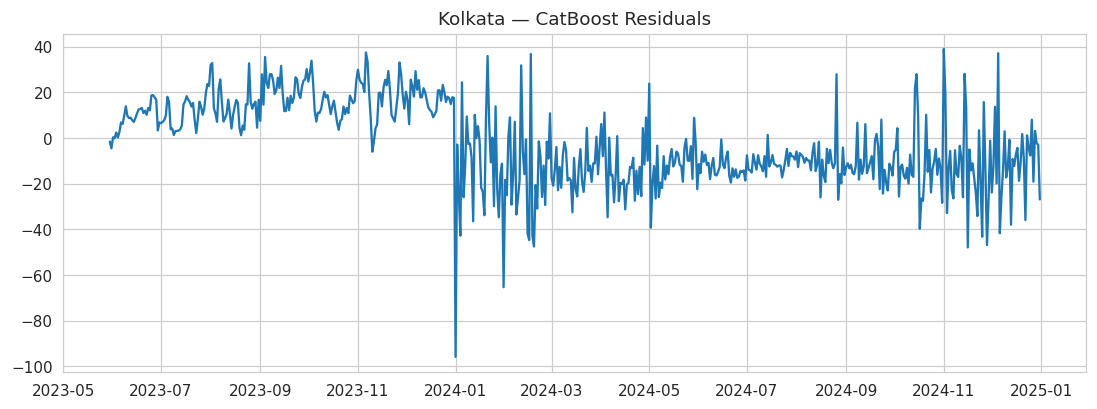

<Figure size 1100x440 with 0 Axes>

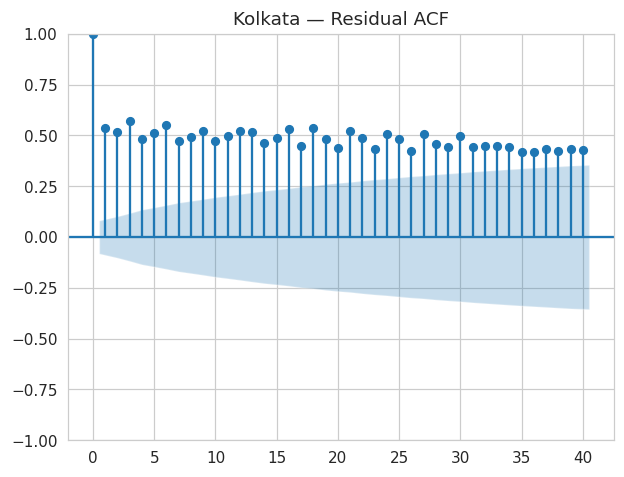


Residual analysis for Mumbai


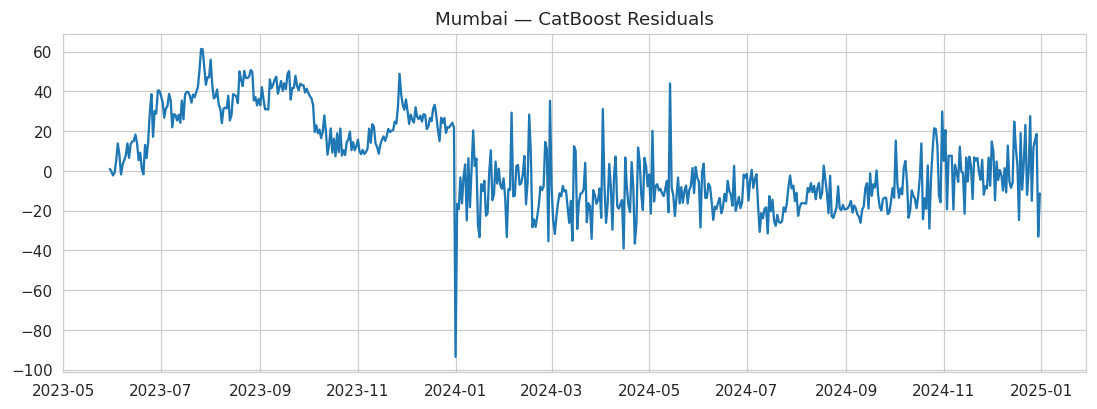

<Figure size 1100x440 with 0 Axes>

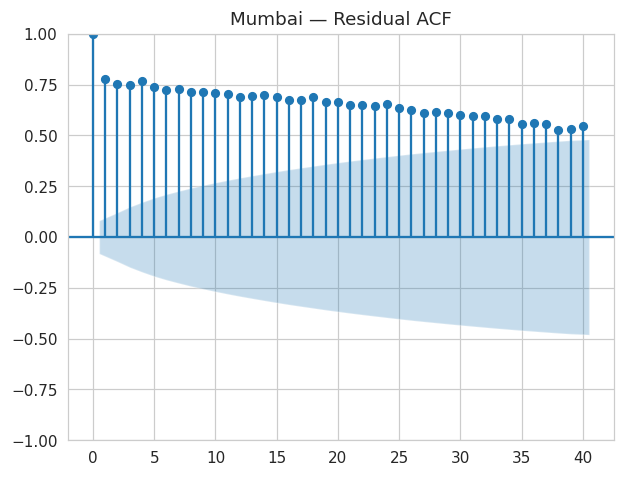

Ljung-Box p-value: 0.0


In [11]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

for city, data in models_store.items():

    residuals = data["y_test"] - data["pred_test"]

    print(f"\nResidual analysis for {city}")

    plt.figure(figsize=(12,4))
    plt.plot(residuals)
    plt.title(f"{city} — CatBoost Residuals")
    plt.show()

    plt.figure(figsize=(10,4))
    plot_acf(residuals, lags=40)
    plt.title(f"{city} — Residual ACF")
    plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box p-value:", lb["lb_pvalue"].values[0])

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

hybrid_store = {}

for city, data in models_store.items():

    print(f"\nHybrid modeling for {city}")

    y_train = data["y_train"]
    y_test  = data["y_test"]
    pred_train = data["pred_train"]
    pred_test  = data["pred_test"]

    residual_train = y_train - pred_train

    try:
        sarimax = SARIMAX(
            residual_train,
            order=(1,1,1),
            seasonal_order=(1,0,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        resid_forecast = sarimax.forecast(steps=len(y_test))
        resid_forecast = pd.Series(resid_forecast, index=y_test.index)

    except Exception as e:
        print(f"{city} — SARIMAX failed, using zero residuals. Error: {e}")
        resid_forecast = pd.Series(np.zeros(len(y_test)), index=y_test.index)

    hybrid_pred = pred_test + resid_forecast

    rmse_hybrid = rmse(y_test, hybrid_pred)
    r2_hybrid = r2_score(y_test, hybrid_pred)

    print(f"{city} — Hybrid RMSE: {rmse_hybrid:.2f}, R2: {r2_hybrid:.3f}")

    hybrid_store[city] = {
        "hybrid_pred": hybrid_pred
    }


Hybrid modeling for Bengaluru
Bengaluru — Hybrid RMSE: 8.72, R2: 0.876

Hybrid modeling for Chennai
Chennai — Hybrid RMSE: 9.51, R2: 0.746

Hybrid modeling for Delhi
Delhi — Hybrid RMSE: 20.53, R2: 0.967

Hybrid modeling for Jaipur
Jaipur — Hybrid RMSE: 18.42, R2: 0.929

Hybrid modeling for Kolkata
Kolkata — Hybrid RMSE: 18.21, R2: 0.968

Hybrid modeling for Mumbai
Mumbai — Hybrid RMSE: 22.72, R2: 0.918


In [14]:
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []

for city in models_store:

    y_test = models_store[city]["y_test"]
    cb_pred = models_store[city]["pred_test"]
    hybrid_pred = hybrid_store[city]["hybrid_pred"]

    results.append({
        "City": city,
        "Model": "CatBoost",
        "RMSE": rmse(y_test, cb_pred),
        "MAE": mean_absolute_error(y_test, cb_pred),
        "MAPE": mape(y_test, cb_pred),
        "R2": r2_score(y_test, cb_pred)
    })

    results.append({
        "City": city,
        "Model": "Hybrid",
        "RMSE": rmse(y_test, hybrid_pred),
        "MAE": mean_absolute_error(y_test, hybrid_pred),
        "MAPE": mape(y_test, hybrid_pred),
        "R2": r2_score(y_test, hybrid_pred)
    })

comparison_df = pd.DataFrame(results)
comparison_df

,City,Model,RMSE,MAE,MAPE,R2
0,Bengaluru,CatBoost,8.729544,6.111242,8.604469,0.876294
1,Bengaluru,Hybrid,8.724887,6.109882,8.613148,0.876426
2,Chennai,CatBoost,9.505833,6.562387,10.119055,0.745681
3,Chennai,Hybrid,9.505344,6.562701,10.121571,0.745707
4,Delhi,CatBoost,20.532024,14.779581,8.504826,0.967322
5,Delhi,Hybrid,20.532398,14.780814,8.506488,0.967321
6,Jaipur,CatBoost,17.583850,14.452091,11.897114,0.935345
7,Jaipur,Hybrid,18.421440,14.859499,13.100401,0.929039
8,Kolkata,CatBoost,18.213285,15.281502,14.684285,0.967835
9,Kolkata,Hybrid,18.214100,15.282139,14.688831,0.967833


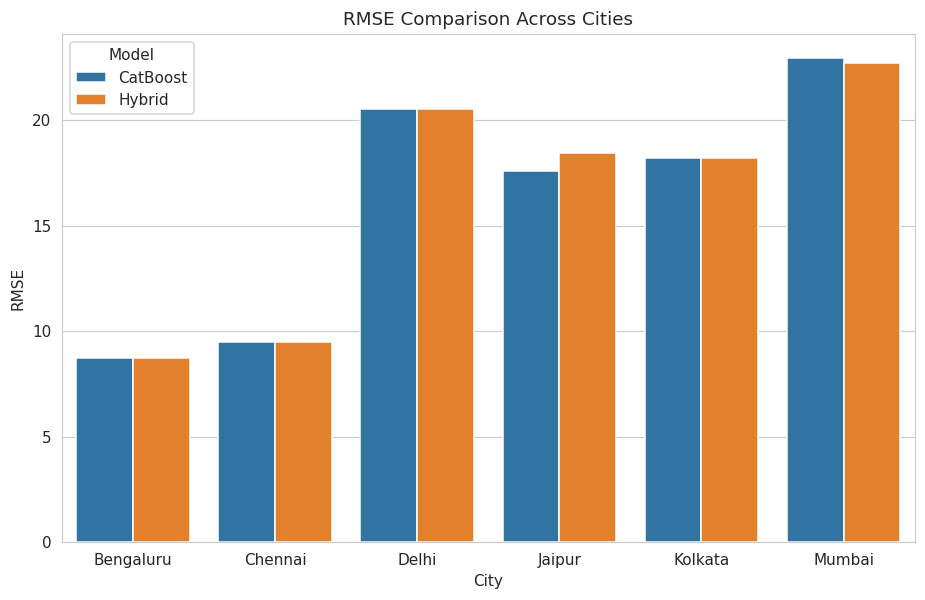

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=comparison_df, x="City", y="RMSE", hue="Model")
plt.title("RMSE Comparison Across Cities")
plt.show()

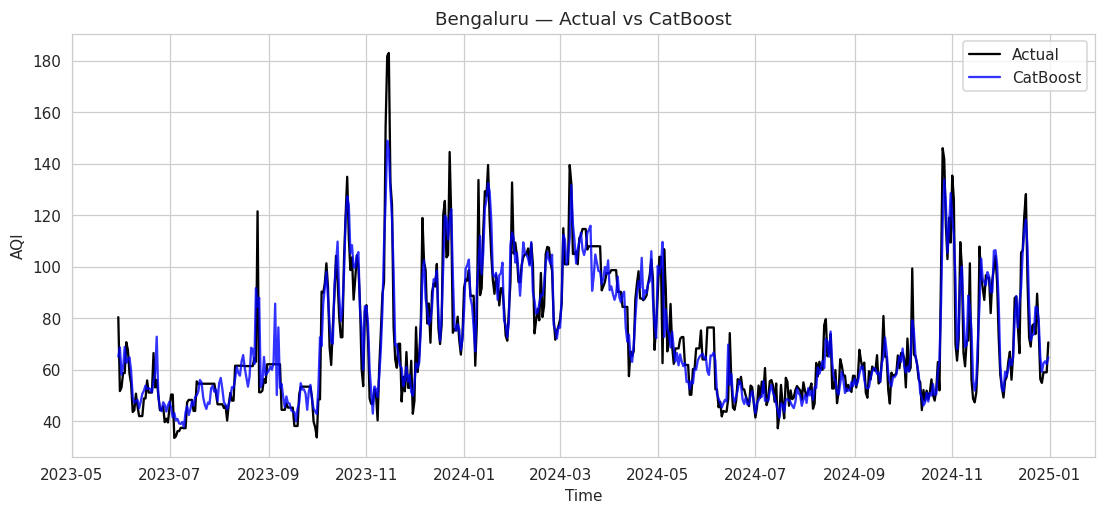

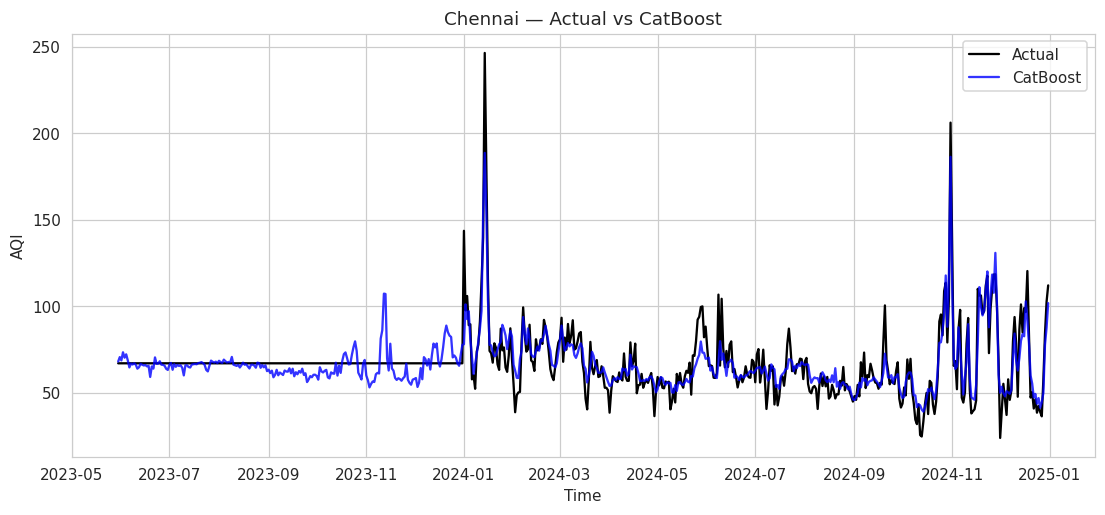

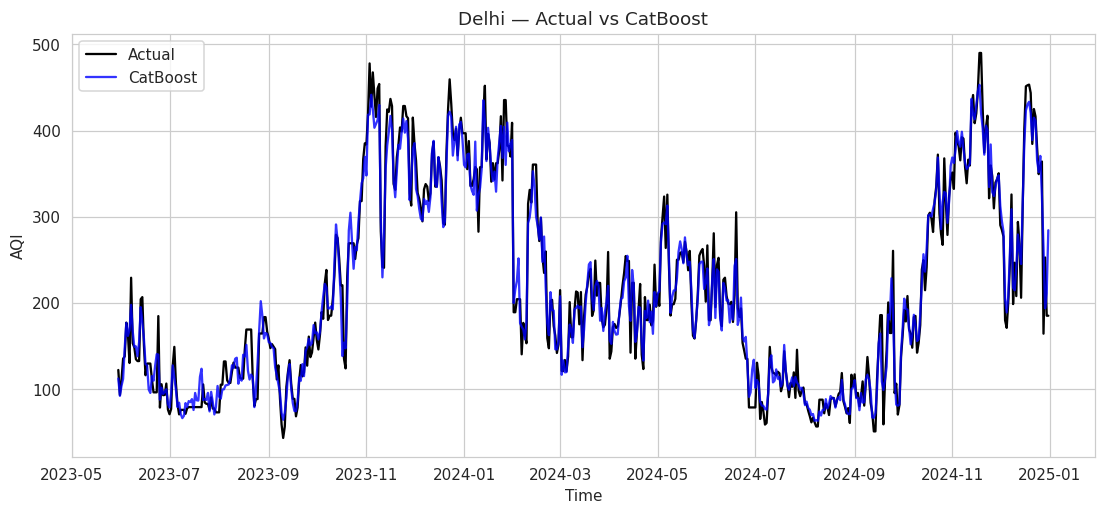

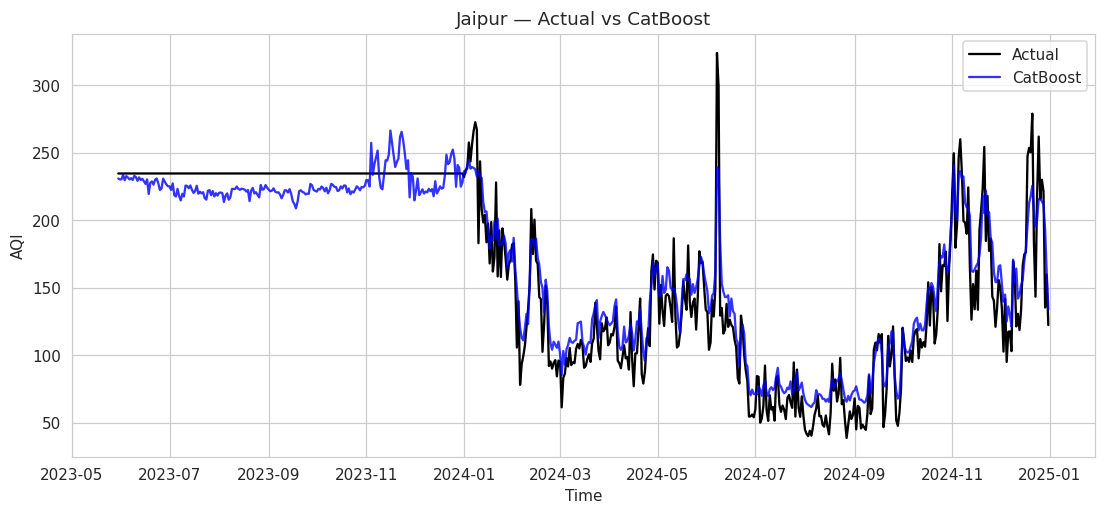

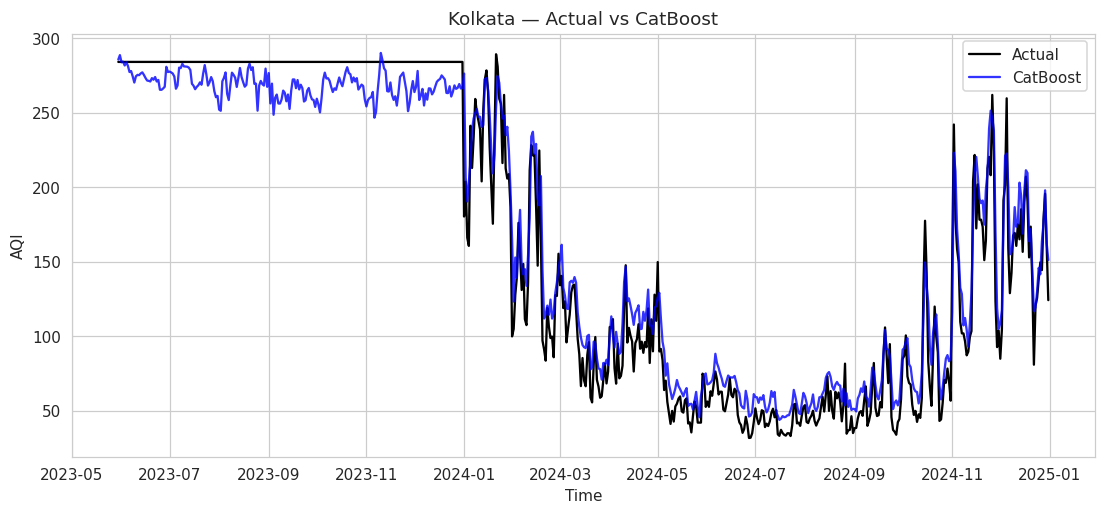

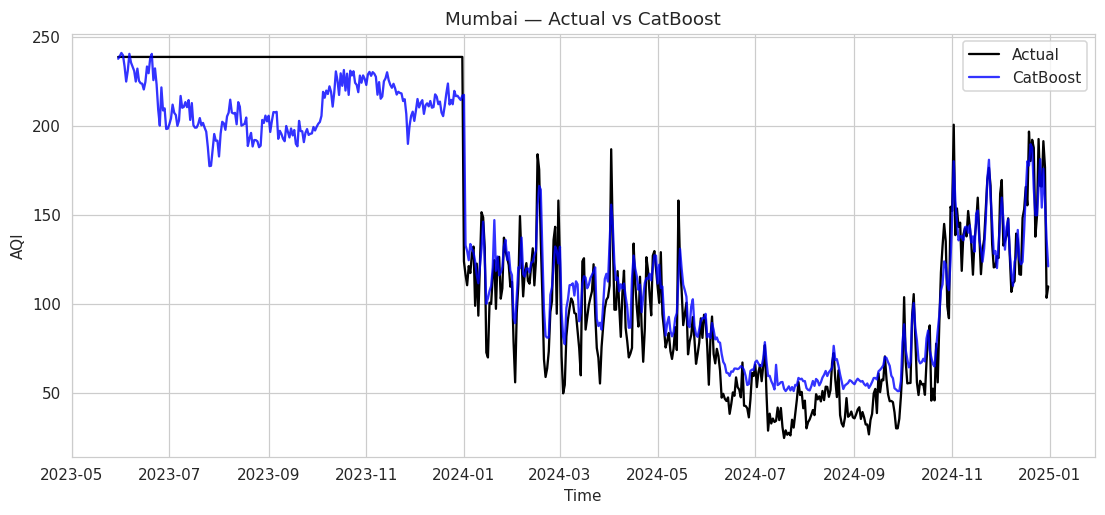

In [16]:
import matplotlib.pyplot as plt

for city, data in models_store.items():

    y_test = data["y_test"]
    pred_test = data["pred_test"]

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test, label="Actual", color="black")
    plt.plot(y_test.index, pred_test, label="CatBoost", color="blue", alpha=0.8)

    plt.title(f"{city} — Actual vs CatBoost")
    plt.xlabel("Time")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()

<Figure size 1100x440 with 0 Axes>

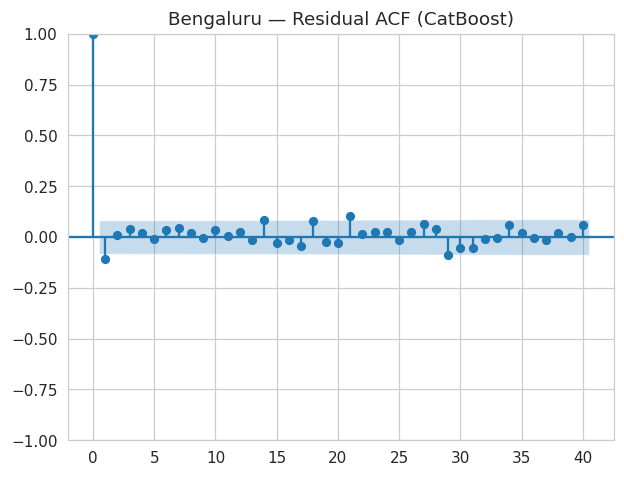

<Figure size 1100x440 with 0 Axes>

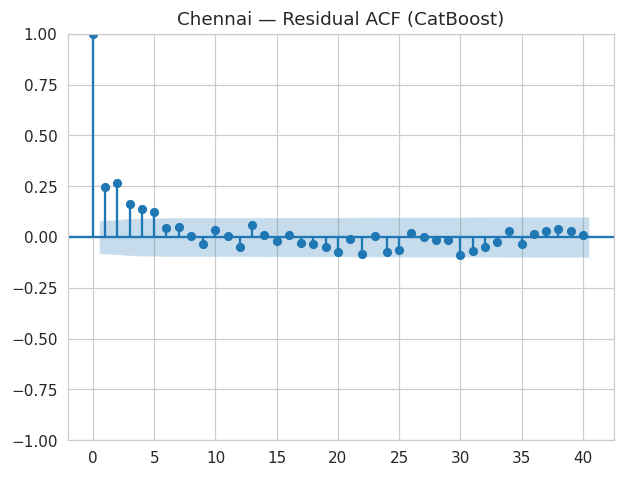

<Figure size 1100x440 with 0 Axes>

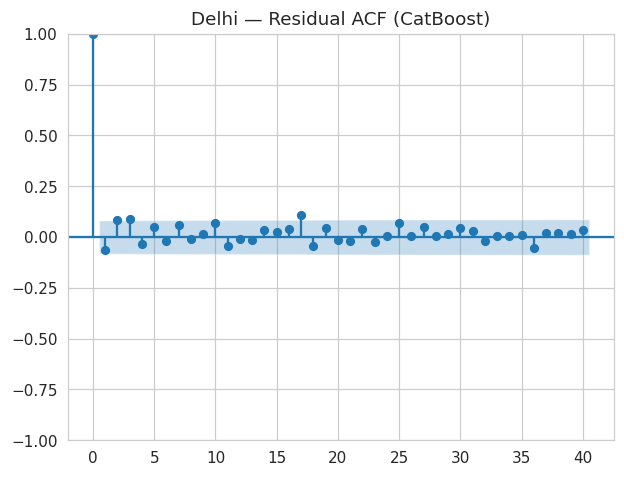

<Figure size 1100x440 with 0 Axes>

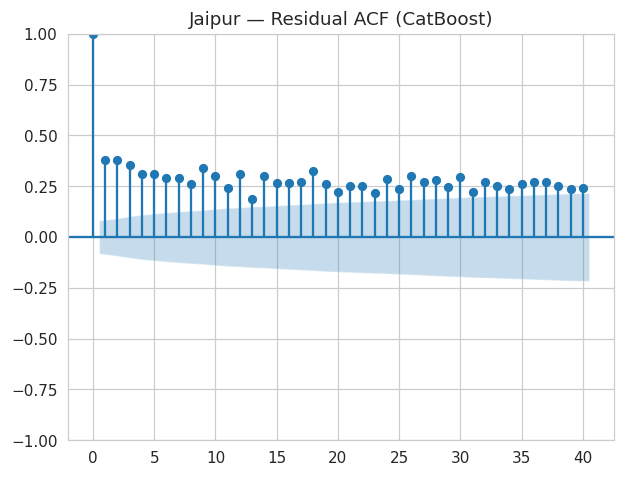

<Figure size 1100x440 with 0 Axes>

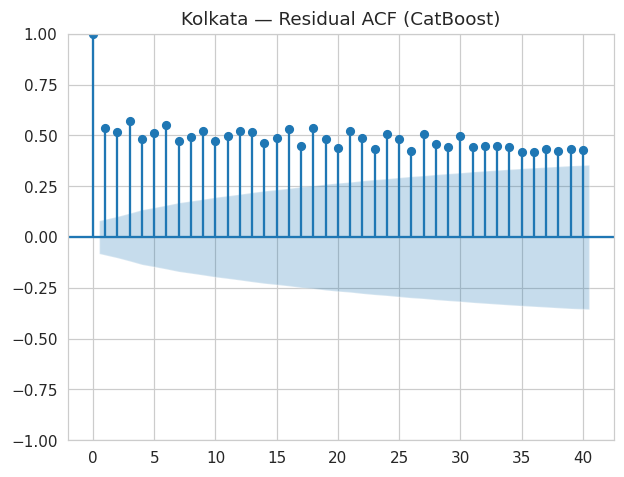

<Figure size 1100x440 with 0 Axes>

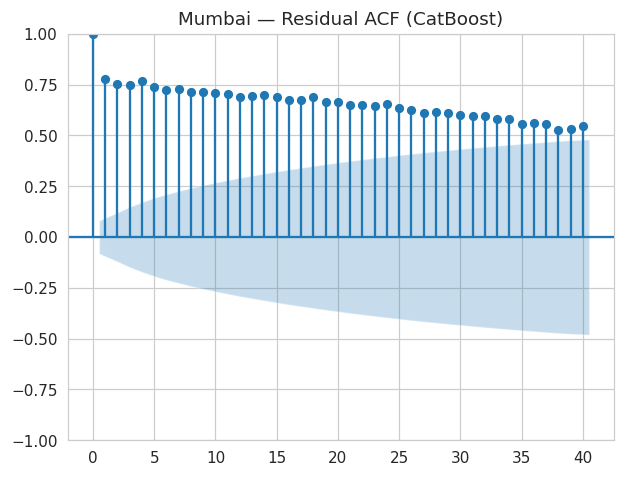

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

for city, data in models_store.items():

    residuals = data["y_test"] - data["pred_test"]

    plt.figure(figsize=(10,4))
    plot_acf(residuals, lags=40)
    plt.title(f"{city} — Residual ACF (CatBoost)")
    plt.show()

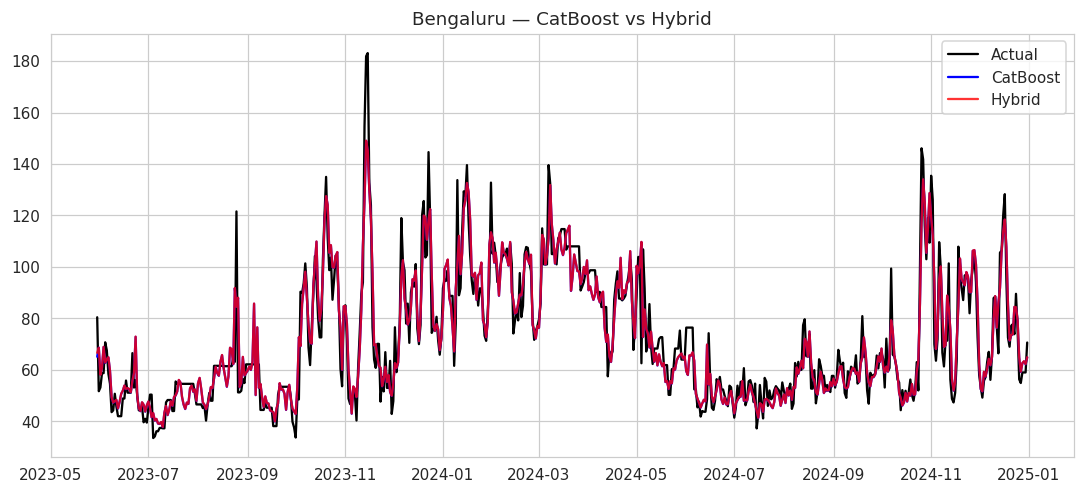

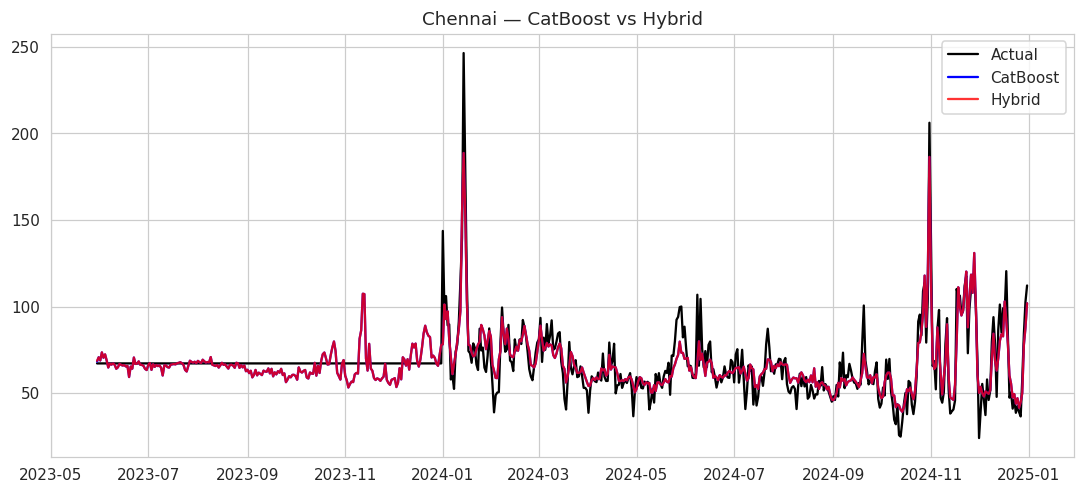

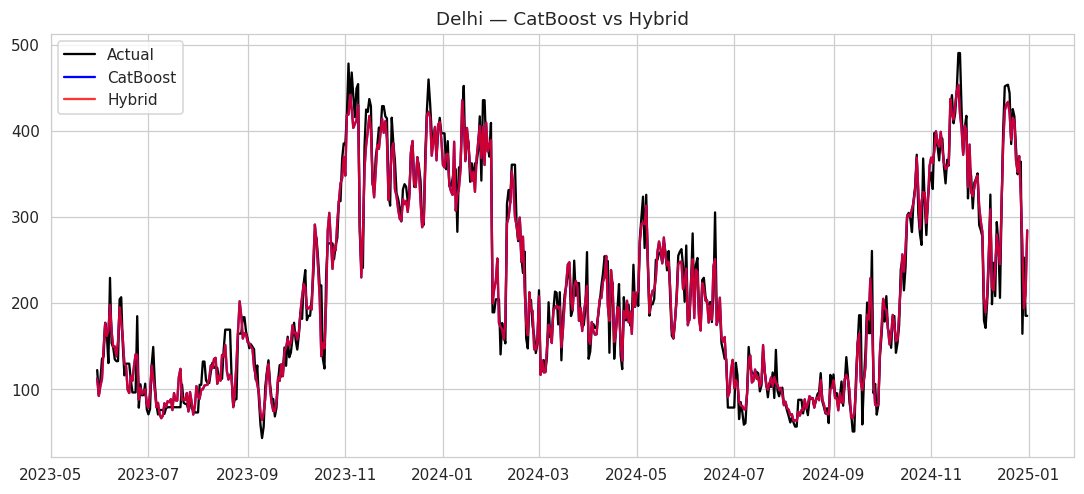

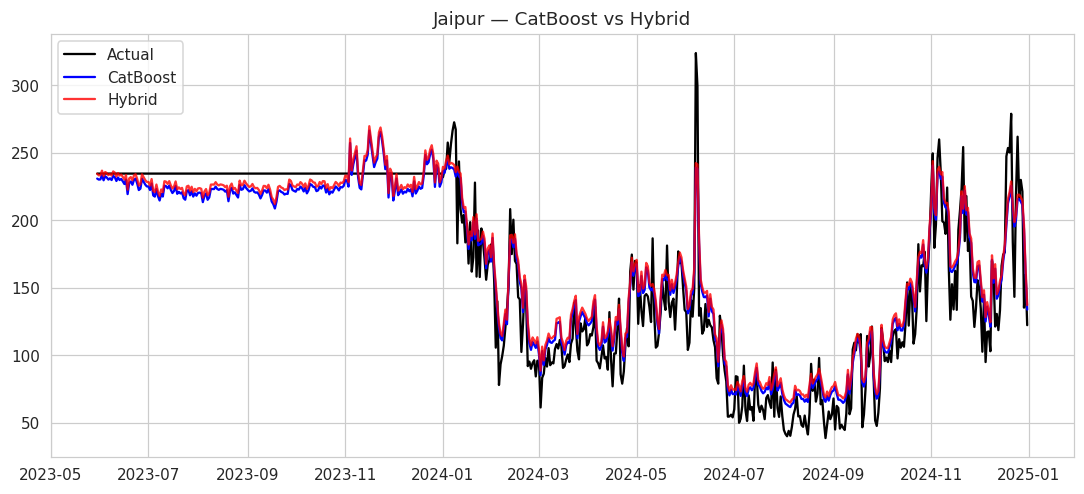

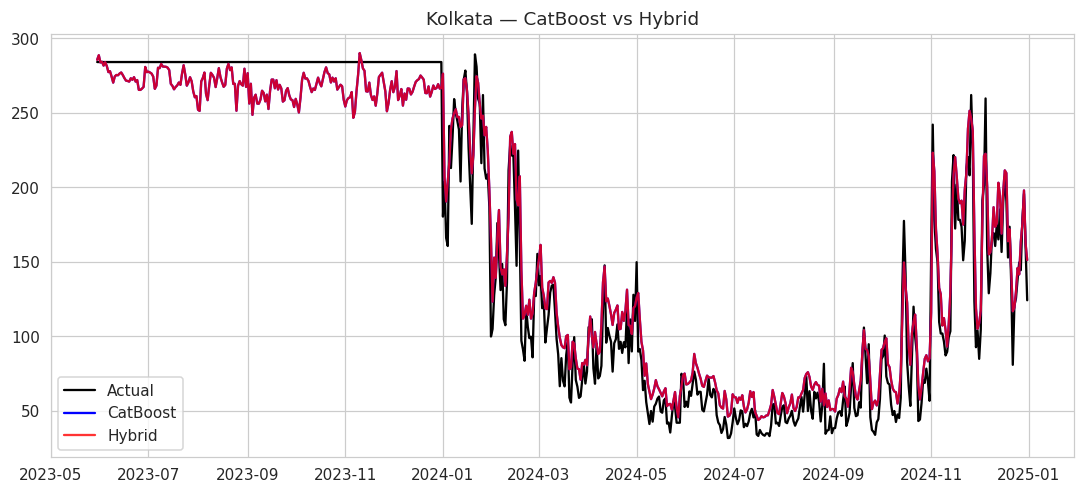

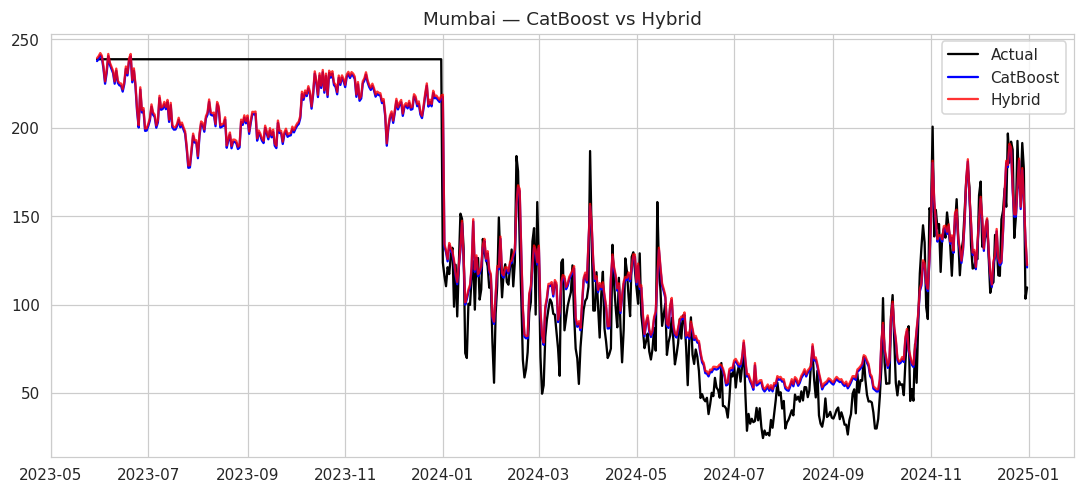

In [18]:
for city in models_store:

    y_test = models_store[city]["y_test"]
    cb_pred = models_store[city]["pred_test"]
    hybrid_pred = hybrid_store[city]["hybrid_pred"]

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test, label="Actual", color="black")
    plt.plot(y_test.index, cb_pred, label="CatBoost", color="blue")
    plt.plot(y_test.index, hybrid_pred, label="Hybrid", color="red", alpha=0.8)

    plt.title(f"{city} — CatBoost vs Hybrid")
    plt.legend()
    plt.show()

## Conclusion

The hybrid CatBoost–SARIMAX framework was evaluated across six Indian metropolitan cities.

Results indicate that CatBoost alone captures most nonlinear and temporal
patterns in AQI data. Hybrid modeling provided marginal improvements in select cities,
suggesting limited residual autocorrelation after primary modeling.

This demonstrates that tree-based boosting models, when combined with
lag-based feature engineering, can effectively model AQI dynamics
without requiring extensive secondary temporal correction.